In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [67]:
def calibrate():
    nx = 9
    ny = 6
    objpoints = []
    imgpoints = []
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    fname = 'camera_cal/calibration2.jpg'
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

def undistort(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img

# cgthreshold

def PTransform():
    area_of_intrest = np.float32([[790, 450], [1170, 700], [100, 700], [490, 450]])
    dstpnt = np.float32([[1780, 0], [1080, 720], [220, 720], [-500, 0]])
    M = cv2.getPerspectiveTransform(area_of_intrest, dstpnt)
    Minv = cv2.getPerspectiveTransform(dstpnt, area_of_intrest)
    return M, Minv

def warp(img):
    img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return img

def findpositionsoflines(binary_warped, windowsimg, left_fit=None, right_fit=None):
    binary_warped_copy = np.copy(binary_warped)
    binary_warped = np.uint8(binary_warped)
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY) 
    binary_warped_fliped = cv2.flip(binary_warped, 0) ####
    nonzero_fliped = binary_warped_fliped.nonzero() ####
    nonzeroy_fliped = np.array(nonzero_fliped[0]) ####
    nonzerox_fliped = np.array(nonzero_fliped[1]) ####
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    global margin
    global minpix
    global nwindows
    minpix = 50
    nwindows = 9
    global window_hight
    global leftx_winds
    global rightx_winds
    window_hight = np.int(binary_warped.shape[0]/nwindows)
    if left_fit != None:
        len_leftx_winds = len(leftx_winds)
        for i in range(len(leftx_winds)):
            leftx_current = leftx_winds[len(leftx_winds) - 1]
            win_y_low = binary_warped.shape[0] - (i+1) * window_hight
            win_y_high = binary_warped.shape[0] - i * window_hight
            win_y_low = i * window_hight
            win_y_high = (i+1) * window_hight
            win_xleft_low = leftx_current - margin            
            win_xleft_high = leftx_current + margin
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            if len(good_left_inds) > minpix:
                leftx_winds[len(leftx_winds) - 1] = np.int(np.mean(nonzerox[good_left_inds]))
                break
            else:
                leftx_winds.remove(leftx_winds[len(leftx_winds) - 1])
        left_lane_inds = build(binary_warped, leftx_winds, 'left', windowsimg, fit=left_fit)
        
        len_rightx_winds = len(rightx_winds)
        for i in range(len(rightx_winds)):
            rightx_current = rightx_winds[len(rightx_winds) - 1]
            win_y_low = i * window_hight
            win_y_high = (i+1) * window_hight
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            if len(good_right_inds) > minpix:
                rightx_winds[len(rightx_winds) - 1] = np.int(np.mean(nonzerox[good_right_inds]))
                break
            else:
                rightx_winds.remove(rightx_winds[len(rightx_winds) - 1])
        right_lane_inds = build(binary_warped, rightx_winds, 'right', windowsimg, fit=right_fit)
    else:
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)        
        midpoint = np.int(histogram.shape[0]/2)
        leftx_current = np.argmax(histogram[:midpoint])
        rightx_current = np.argmax(histogram[midpoint:]) + midpoint
        left_lane_inds = build(binary_warped, leftx_winds, 'left', windowsimg, center=leftx_current)
        right_lane_inds = build(binary_warped, rightx_winds, 'right', windowsimg, center=rightx_current)
        
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    windowsimg[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    windowsimg[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty

def build (binary_warped, winds, side, windowsimg, center=None, fit=None):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    lane_inds = []
    for i in range(len(winds)):
        center = winds[i]
        good_inds = find_good_inds(binary_warped, i, center + (fit[0] * 100000))
        lane_inds.append(good_inds)
    
    for i in range(len(winds), nwindows):
        good_inds = find_good_inds(binary_warped, i, center)
        lane_inds.append(good_inds)
        
        if len(good_inds) > minpix:            
            if side =='left':
                leftx_winds.append(center)
            else:
                rightx_winds.append(center)
            center = np.int(np.mean(nonzerox[good_inds]))
        else:
            if side == 'left':
                leftx_winds.append(center)
            else:
                rightx_winds.append(center)
    
    lane_inds = np.concatenate(lane_inds)
    
    return lane_inds

def find_good_inds(binary_warped, i, center):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    win_y_low = binary_warped.shape[0] - (i+1)*window_hight
    win_y_high = binary_warped.shape[0] - i*window_hight
    win_x_low = int(center - margin)
    win_x_high = int(center + margin)
    cv2.rectangle(windowsimg,(win_x_low,win_y_low),(win_x_high,win_y_high), (0,255,0), 3)

    good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
    
    if len(good_inds) > 5000:
        good_inds = [good_inds[0]]

    return good_inds

def findlines(leftx, lefty, rightx, righty, windowsimg):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, windowsimg.shape[0]-1, windowsimg.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ploty = ploty.reshape(ploty.shape[0], 1)
    left_fitx = left_fitx.reshape(left_fitx.shape[0], 1)
    right_fitx = right_fitx.reshape(right_fitx.shape[0], 1)

    left = np.hstack((left_fitx, ploty))
    right = np.hstack((right_fitx, ploty))
    cv2.polylines(windowsimg, np.int32([left]), False, (255, 255, 255), thickness=4)
    cv2.polylines(windowsimg, np.int32([right]), False, (255, 255, 255), thickness=4)
    
    return left_fit, right_fit

def findradius(leftx, lefty, rightx, righty, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)

    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def findOffset(binary_warp, left_fit, right_fit):
    leftline = left_fit[0]*binary_warp.shape[0]**2 + left_fit[1]*binary_warp.shape[0] + left_fit[2]
    rightline = right_fit[0]*binary_warp.shape[0]**2 + right_fit[1]*binary_warp.shape[0] + right_fit[2]
    pixeloffset = ((leftline + rightline) / 2) - (binary_warp.shape[1] / 2)
    xm_per_pix = 3.7/700
    offset = pixeloffset * xm_per_pix
    return offset

def drawonlane(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    color_warp = np.zeros_like(img).astype(np.uint8)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

def puttext(img, left_curverad, right_curverad, offset):
    text = "left curverad: " + str(left_curverad)
    img = cv2.putText(img, text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    text = "right curverad: " + str(right_curverad)
    img = cv2.putText(img, text, (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    text = "offset: " + str(offset)
    img = cv2.putText(img, text, (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    return img

def saveImage(img, name, save):
    if save:
        cv2.imwrite('output_images/' + name + '.jpg', img)

In [68]:
mtx, dist = calibrate()
M, Minv = PTransform()
left_fit, right_fit = None, None
window_hight = None
margin = 100
minpix = 50
leftx_winds, rightx_winds = [], []

In [69]:
def process_image(image):
    result = pipeline(image)
    return result

In [77]:
def pipeline(img, save=False):
    global picnum
    global left_fit
    global right_fit
    global windowsimg
    dst = undistort(img)
    binary = cgthreshold(dst)
    binary_warp = warp(binary)
    binary_warped_like = np.uint8(binary_warp)
    binary_warped_like = cv2.cvtColor(binary_warped_like, cv2.COLOR_BGR2GRAY)
    windowsimg = np.dstack((binary_warped_like, binary_warped_like, binary_warped_like))*255
    leftx, lefty, rightx, righty = findpositionsoflines(binary_warp, windowsimg, left_fit, right_fit)
    left_fit, right_fit = findlines(leftx, lefty, rightx, righty, windowsimg)
    left_curverad, right_curverad = findradius(leftx, lefty, rightx, righty, binary_warp)
    offset = findOffset(binary_warp, left_fit, right_fit)
    lanedraw = drawonlane(img, left_fit, right_fit)
    textimg = puttext(lanedraw, left_curverad, right_curverad, offset)
    binary = binary * 255
    binary_warp = binary_warp * 255
    horizontal1 = np.hstack((binary, binary_warp))
    horizontal2 = np.hstack((windowsimg, textimg))
    result = np.vstack((horizontal1, horizontal2))
    saveImage(dst, 'undistorted', save)
    saveImage(binary, 'binary', save)
    saveImage(binary_warp, 'binary_warped', save)
    saveImage(windowsimg, 'windows_img', save)
    saveImage(textimg, 'result', save)
    
    picnum += 1
    cv2.imwrite('flow/' + str(picnum) + '.jpg', windowsimg)
    plt.imshow(lanedraw)
    return result

In [78]:
def cgthreshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    combined_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

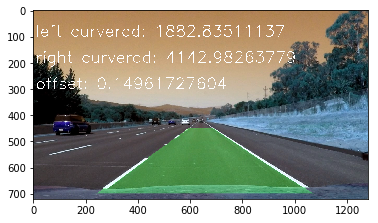

In [79]:
picnum = 0
left_fit, right_fit, windowsimg = None, None, None
leftx_winds, rightx_winds = [], []
image = cv2.imread('test_images/straight_lines2.jpg')
results = pipeline(image, save=True)

In [7]:
picnum = 0
left_fit, right_fit, windowsimg = None, None, None
leftx_winds, rightx_winds = [], []
project_video = 'project_video_output.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(37, 45)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [41:17<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 41min 28s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video))